# SVM On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
    9.1 TF-IDF weighted W2V
10. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using Support Vector Machine(SVM) algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words, TF-IDF, avg Word2Vec, TF-IDF weighted Word2Vec. 

In [2]:
# loading required libraries 
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import scipy 
import nltk
import time
import seaborn as sns 
from scipy import stats
from matplotlib import pyplot as plt 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as prf1

from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

import warnings 
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

#Applying dimensionality reduction 
def truncated_svd(data):
    svd = TruncatedSVD(n_components = 1000, random_state = 0)
    svd_val = svd.fit_transform(data)
    print(np.sum(svd.explained_variance_ratio_))
    return svd_val

## 3. Loading the data

In [4]:
#Loading the data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

Loading the pre-processed data using sqlite. This dataset has no entry with score 3 which is previously removed. And the scores which are greater than 3 are denoted as 'positive' and which are less than 3 are denoted as 'negative' scores.

In [5]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing

In [6]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
# sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [8]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [9]:
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [10]:
sorted_data.shape

(364171, 12)

In [11]:
score = np.array(sorted_data.Score.reshape(364171,1))

## 5. Function Definitions

### [A.] Data Spliting 

In [12]:
# spliting the data
def data_split(data, score):
    # train data 70% and test data 30%
    train_x, test_x, train_y, test_y = train_test_split(data, score, test_size=0.3, shuffle = False)    
    return train_x, test_x, train_y, test_y

### [B.] Linear Support Vector Classifier 

In [13]:
# applying Support Vector Classifier 
def svc_sgd(X, Y, vectorizer):

    cv_err = []
    train_err = []
    a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=10)
    for train, cv in Kfold.split(X):
        for a in a_val:
                
            vect_model = vectorizer.fit(X.iloc[train]['CleanedText'].values)
            train_vect = vect_model.transform(X.iloc[train]['CleanedText'].values)
            cv_vect = vect_model.transform(X.iloc[cv]['CleanedText'].values)
            
            clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', n_jobs = -1) 
            clf.fit(train_vect, Y[train])
            train_err.append(1 - (clf.score(train_vect, Y[train])))
            cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            
    return train_err, cv_err

In [65]:
# applying Support Vector Classifier for W2V
def sgd_w2v(X, Y):
    
    cv_err = []
    train_err = []
    a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=None)
    for train, cv in Kfold.split(X):
        for a in a_val:
                
            w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=8)
            train_vect = avg_w2v(X[train], w2v_model)
            cv_vect = avg_w2v(X[cv], w2v_model)
            
            clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', n_jobs = -1) 
            clf.fit(train_vect, Y[train])
                
            cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            train_err.append(1 - (clf.score(train_vect, Y[train])))
                    
    return train_err, cv_err

In [77]:
# applying Support Vector Classifier for tfidf-w2v
def sgd_tfidf_w2v(X1, Y, raw_x):
    X = np.array(X1)
    cv_err = []
    train_err = []
    a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=None)
    for train, cv in Kfold.split(X):
        for a in a_val:
                
            w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=-1)
            tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
            train_vect = tfidf_w2v(X1[cv.shape[0]:], w2v_model, tfidf_dict)
            cv_vect = tfidf_w2v(X1[:cv.shape[0]], w2v_model, tfidf_dict)
                
            train_vect = np.nan_to_num(train_vect)
            cv_vect = np.nan_to_num(cv_vect)
            
            clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', n_jobs = -1)
            clf_model.fit(train_vect, Y[train])
                
            cv_err.append(1 - (clf_model.score(cv_vect, Y[cv])))
            train_err.append(1 - (clf_model.score(train_vect, Y[train])))
                    
    return cv_err, train_err

### [C.] Error Curve 

In [14]:
# comparing error between cv and train data
def error_comparision(cv_err, train_err):
    sns.set()
    a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(a_val, cv_err[i,:],label = 'cv_error', color = 'r')
        plt.plot(a_val, train_err[i,:],label = 'train_error', color = 'b')
        plt.xscale('log')
        plt.xlabel('C-Values')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TRAIN-ERR for Fold '+str(i+1))

### [D.] Accuracy Metrics 

In [15]:
# train and test accuracy and ROC plot
def final_test_acc(train_data, train_score, test_data, test_score, best_a, name):

    clf = SGDClassifier(loss = 'hinge', alpha = best_a, class_weight='balanced', n_jobs = -1)
    clf.fit(train_data, train_score)
    
    # Train Metric
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred_trn = clf.predict(train_data)
    acc_trn = accuracy_score(train_score, pred_trn, normalize=True) * float(100)
    print("\nTrain accuracy for alpha = '{0}' is '{1}'".format(best_a, acc_trn))
    score_roc = clf.decision_function(train_data)
    fpr0, tpr0, thresholds0 = roc_curve(train_score, score_roc)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr0, tpr0, label='SVC', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('SVC ROC curve for '+name+' with alpha '+str(best_a))
    plt.show()
    print('Area under the ROC curve is ', roc_auc_score(train_score, score_roc))
    conf_matx_trn = confusion_matrix(train_score, pred_trn)
    print('\nConfusion Matrix :\n', conf_matx_trn)
    norm_conf_matx_trn = conf_matx_trn / conf_matx_trn.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx_trn)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx_trn, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision_trn, recall_trn, fscore_trn, support_trn = prf1(train_score, pred_trn)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision_trn[0]*100, precision_trn[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall_trn[0]*100, recall_trn[1]*100))
    print('F1-score   : {}'.format(fscore_trn))
    plt.show()
    
    
    
    # Test Metric
    
    print('\t\t\t\tACCURACY METRIC FOR TEST-SET\n')
    pred = clf.predict(test_data)
    acc = accuracy_score(test_score, pred, normalize = True) * float(100)
    print("\nTest accuracy for alpha = '{0}' is '{1}'".format(best_a, acc))
    
    score_roc = clf.decision_function(test_data)
    fpr, tpr, thresholds = roc_curve(test_score, score_roc)
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='SVC', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('SVC ROC curve for '+ name)
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(test_score, score_roc))
    conf_matx = confusion_matrix(test_score,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_score, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

### [E.] Grid Search 

In [16]:
# applying grid search to find best alpha 
def grid_search_cv(data_trn, score_trn, data_test, score_test):
    
    parameter = [{'alpha': [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]}]
            
    model = GridSearchCV(SGDClassifier(loss = 'hinge', class_weight='balanced', n_jobs = -1), parameter, scoring = 'f1', cv=3, n_jobs = -1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [F.] Random Search 

In [17]:
# applying random search to find best alpha
def random_search_cv(data_trn, score_trn, data_test, score_test):
    
    parameter={'alpha': scipy.stats.norm(0.0001, 0.00001)}
            
    model = RandomizedSearchCV(SGDClassifier(loss = 'hinge', class_weight='balanced', n_jobs = -1), parameter, scoring = 'f1', cv=3, n_jobs = -1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [G.] Important Features 

In [18]:
# finding top features for each class
def top_features(data, score, vectorizer, top_n, a):

    clf = SGDClassifier(alpha = a, class_weight = 'balanced', loss = 'hinge', n_jobs = -1)
    clf.fit(data, score)
    
    # sorting the weight indices 
    pos_class_weight_sorted = -clf.coef_.argsort()
    neg_class_weight_sorted = clf.coef_.argsort()
    
    # top negative features
    print('Top '+str(top_n)+' "NEGATIVE" Features are:\n')
    neg = np.take(vectorizer.get_feature_names(), neg_class_weight_sorted[:top_n])
    for i in range(top_n):
        print(neg[0][i])
        
    # top positive features 
    print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
    pos = np.take(vectorizer.get_feature_names(), pos_class_weight_sorted[:top_n])
    for i in range(top_n):
        print(pos[0][i])

## 6. Bag of Words (BoW)

In [19]:
train_x, test_x, train_y, test_y = data_split(sorted_data[:100000], score[:100000])

In [20]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,2), min_df = 0)

### [A.] Linear Support Vector Classifier 

In [21]:
# applying linear svc
train_err, cv_err = svc_sgd(train_x, train_y, count_vect)

In [22]:
cv_err = np.reshape(cv_err,(3, 13))
train_err = np.reshape(train_err,(3, 13))

### [B.] Error Plot Over Different Values of Hyperparameter alpha (α)

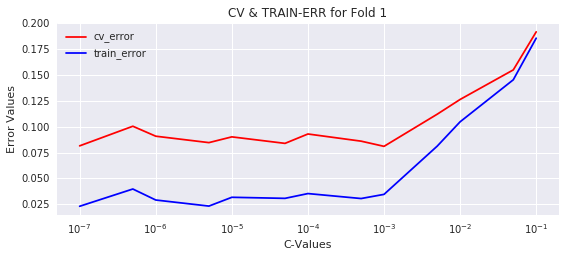

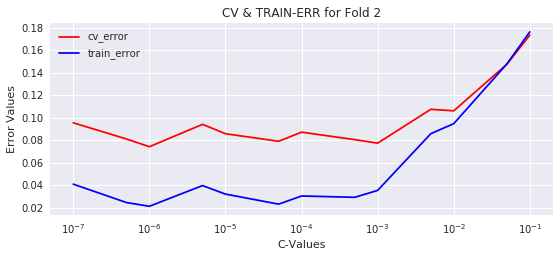

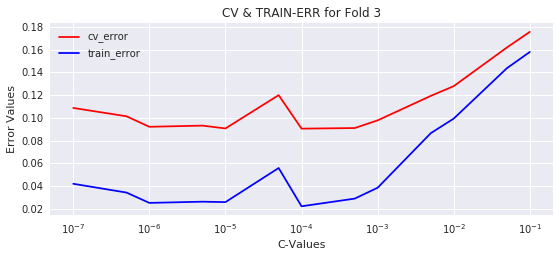

In [23]:
# error plot between cv error and train error 
error_comparision(cv_err, train_err)

In [24]:
# applying bow to test and train data 
bow_model = count_vect.fit(train_x['CleanedText'].values)
final_counts_train = bow_model.transform(train_x['CleanedText'].values)
final_counts_test = bow_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [25]:
# finding best fit alpha using grid search 
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9435641588505289


### [D.] Random Search 

In [26]:
# finding best fit alpha using random search 
random_search_cv(final_counts_train, train_y, final_counts_test, test_y)

SGDClassifier(alpha=0.00010597592272666115, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
0.9518643271189096


### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for alpha = '0.0001' is '97.07571428571428'


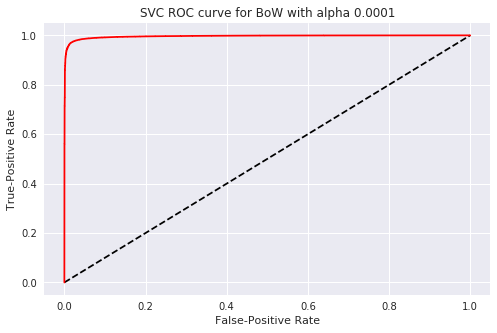

Area under the ROC curve is  0.9962235006337351

Confusion Matrix :
 [[ 8043   125]
 [ 1922 59910]]

Normalized Confusion Matrix :
 [[0.98469638 0.01530362]
 [0.03108423 0.96891577]]

Precision  : 80.71%, 99.79%
Recall     : 98.47%, 96.89%
F1-score   : [0.8871119 0.983203 ]


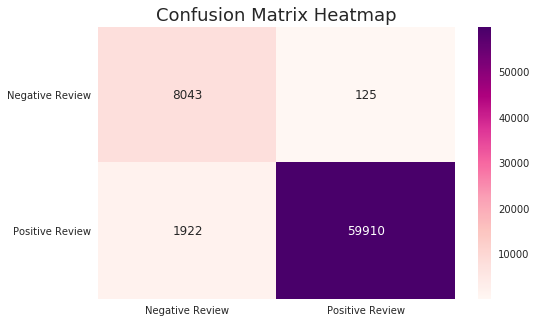

				ACCURACY METRIC FOR TEST-SET


Test accuracy for alpha = '0.0001' is '91.01333333333334'


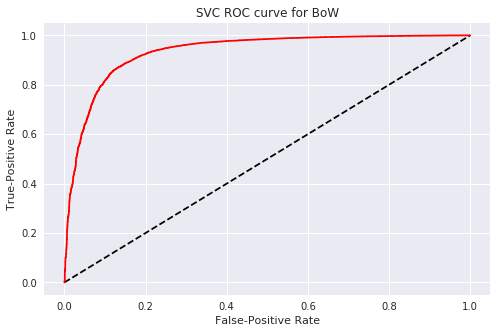

Area under the ROC curve is  0.9335702364504027

Confusion Matrix :
 [[ 3264   839]
 [ 1857 24040]]

Normalized Confusion Matrix :
 [[0.79551548 0.20448452]
 [0.07170715 0.92829285]]

Precision  : 63.74%, 96.63%
Recall     : 79.55%, 92.83%
F1-score   : [0.70771899 0.94690405]


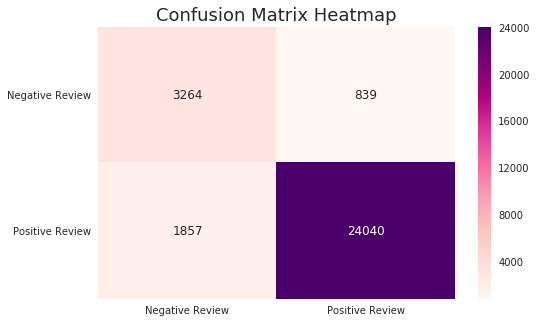

In [27]:
# accuracy measures for train and test data
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 0.0001, 'BoW')

### [F.] Top Features from Each Class

In [28]:
# printing top features(i.e words here) for each class
top_features(final_counts_train, train_y, count_vect, 10, 0.0001)

Top 10 "NEGATIVE" Features are:

worst
not worth
terribl
disappoint
aw
two star
wors
kona pod
bland
not recommend

Top 10 "POSITIVE" Features are:

ago food
haul began
butter pie
satisfact say
vent duct
beef fresh
ago presid
made odd
town parma
head bottl


## 7. TF-IDF

In [29]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 0)

### [A.] Linear Support Vector Classifier 

In [30]:
# applying linear svc
train_err, cv_err = svc_sgd(train_x, train_y, tf_idf_vect)

In [31]:
cv_err = np.reshape(cv_err,(3, 13))
train_err = np.reshape(train_err,(3, 13))

### [B.] Error Plot Over Different Values of Hyperparameter alpha (α)

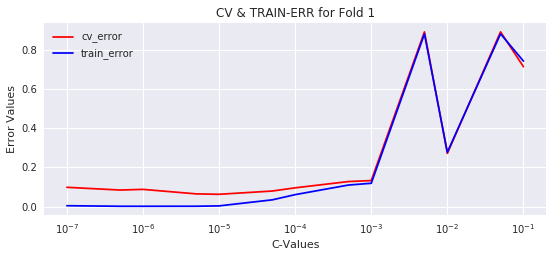

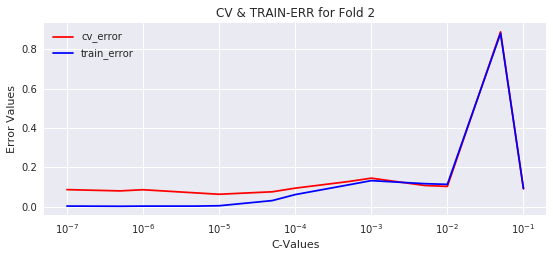

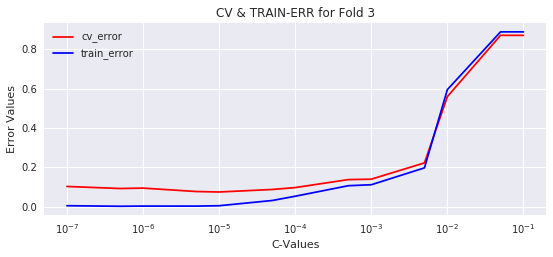

In [32]:
# error plot between cv error and test error 
error_comparision(cv_err, train_err)

In [33]:
# applying tfidf to test and train data
tfidf_model = tf_idf_vect.fit(train_x['CleanedText'].values)
final_counts_train = tfidf_model.transform(train_x['CleanedText'].values)
final_counts_test = tfidf_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [34]:
# finding best fit alpha using grid search 
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.957079697953754


### [D.] Random Search 

In [35]:
# finding best fit alpha using random search 
random_search_cv(final_counts_train, train_y, final_counts_test, test_y)

SGDClassifier(alpha=7.778559360208001e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
0.9378954580260347


### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for alpha = '1e-05' is '99.08285714285714'


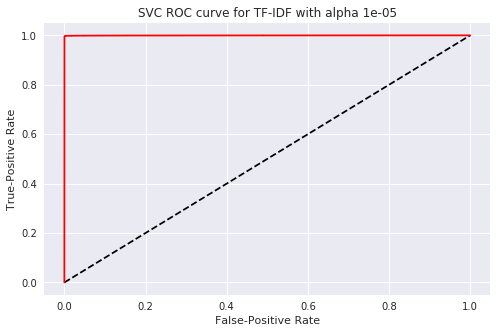

Area under the ROC curve is  0.9996629450592416

Confusion Matrix :
 [[ 8167     1]
 [  641 61191]]

Normalized Confusion Matrix :
 [[9.99877571e-01 1.22428991e-04]
 [1.03668004e-02 9.89633200e-01]]

Precision  : 92.72%, 100.00%
Recall     : 99.99%, 98.96%
F1-score   : [0.9621819  0.99478151]


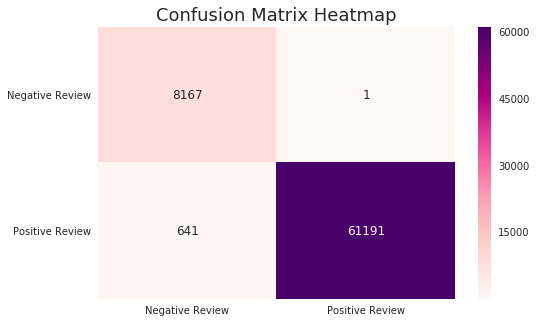

				ACCURACY METRIC FOR TEST-SET


Test accuracy for alpha = '1e-05' is '92.86999999999999'


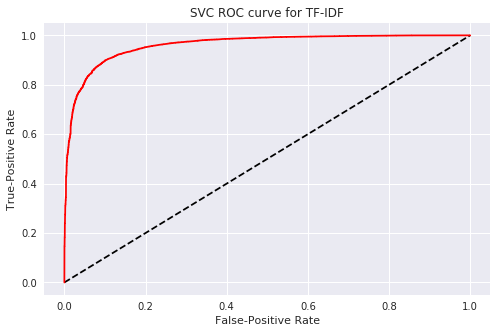

Area under the ROC curve is  0.9610561736109935

Confusion Matrix :
 [[ 3324   779]
 [ 1360 24537]]

Normalized Confusion Matrix :
 [[0.81013892 0.18986108]
 [0.05251574 0.94748426]]

Precision  : 70.96%, 96.92%
Recall     : 81.01%, 94.75%
F1-score   : [0.75657221 0.95823326]


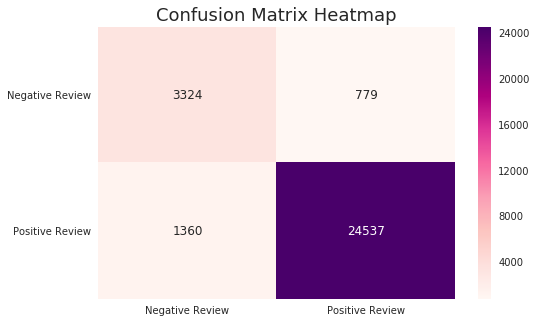

In [39]:
# accuracy measures for train and test
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 0.00001, 'TF-IDF')

### [F.] Top Features from Each Class

In [40]:
# printing top features(i.e words here) for each class
top_features(final_counts_train, train_y, tf_idf_vect, 10, 0.00001)

Top 10 "NEGATIVE" Features are:

disappoint
not worth
worst
bland
unfortun
terribl
not
not recommend
threw
return

Top 10 "POSITIVE" Features are:

satisfact say
haul began
ago food
town parma
bazaar near
butter pie
healthiest best
head bottl
brand ginger
earli great


## 8. Word2Vec

In [41]:
#Importing Libraries 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [42]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [43]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [45]:
print(sorted_data['Text'].values[0])
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


## 9. Avg Word2Vec & TF-IDF Word2Vec

In [46]:
#Determining average Word2Vec for each review
def avg_w2v(data, model):
    sent_vectors = []
    for sent in data: 
        sent_vec = np.zeros(100) 
        cnt_words =0; 
        for word in sent: # for each word in a review/sentence
            try:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)

In [48]:
train_x, test_x, train_y, test_y = data_split(list_of_sent[:100000], score[:100000])

### [A.] Linear Support Vector Classifier 

In [66]:
# applying linear svc
train_err, cv_err = sgd_w2v(np.array(train_x), np.array(train_y))

In [67]:
cv_err = np.reshape(cv_err,(3, 13))
train_err = np.reshape(train_err,(3, 13))

### [B.] Error Plot Over Different Values of Hyperparameter alpha (α)

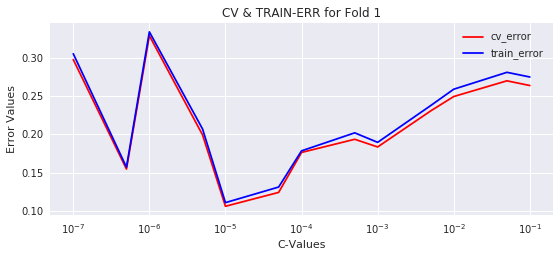

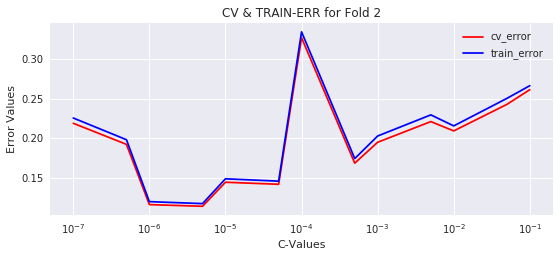

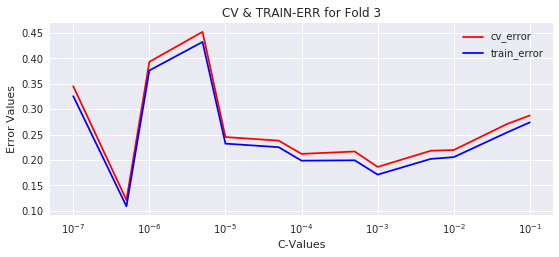

In [68]:
# error plot between cv error and test error 
error_comparision(cv_err, train_err)

In [69]:
# applying w2v to train and test data
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=8)
train_vect = avg_w2v(train_x, w2v_model)
test_vect = avg_w2v(test_x, w2v_model)

In [70]:
train_vect = np.nan_to_num(train_vect)
test_vect = np.nan_to_num(test_vect)

### [C.] Grid Search 

In [71]:
# finding best fit alpha using grid search
grid_search_cv(train_vect, train_y, test_vect, test_y)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.8920728664115788


### [D.] Random Search 

In [72]:
# finding best fit alpha using grid search
random_search_cv(train_vect, train_y, test_vect, test_y)

SGDClassifier(alpha=0.00010568422315707997, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
0.9109054618036654


### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for alpha = '0.001' is '75.45714285714286'


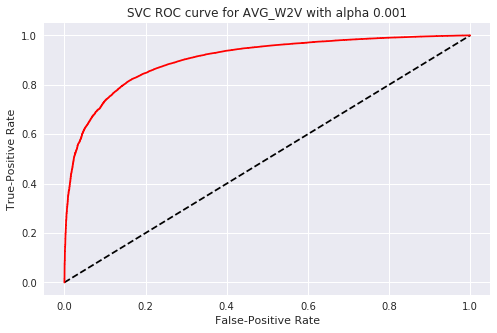

Area under the ROC curve is  0.9041389800237831

Confusion Matrix :
 [[ 7348   820]
 [16360 45472]]

Normalized Confusion Matrix :
 [[0.89960823 0.10039177]
 [0.26458792 0.73541208]]

Precision  : 30.99%, 98.23%
Recall     : 89.96%, 73.54%
F1-score   : [0.46103652 0.84110836]


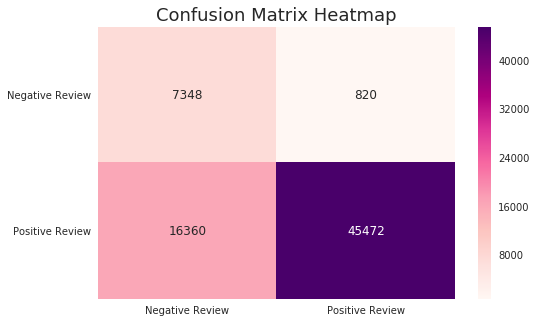

				ACCURACY METRIC FOR TEST-SET


Test accuracy for alpha = '0.001' is '74.85333333333334'


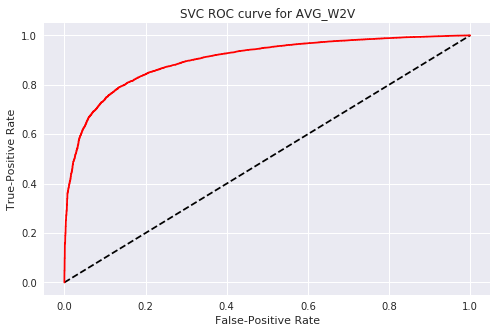

Area under the ROC curve is  0.901530276237937

Confusion Matrix :
 [[ 3741   362]
 [ 7182 18715]]

Normalized Confusion Matrix :
 [[0.91177187 0.08822813]
 [0.27732942 0.72267058]]

Precision  : 34.25%, 98.10%
Recall     : 91.18%, 72.27%
F1-score   : [0.49793691 0.83225864]


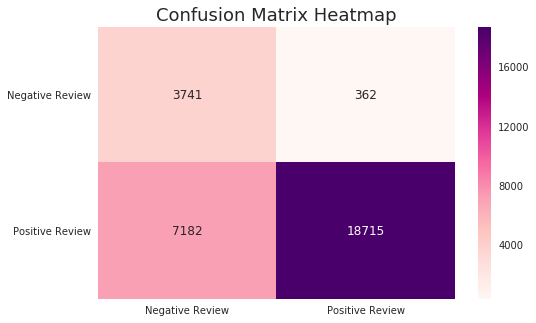

In [74]:
# accuracy matric for train and test data
final_test_acc(train_vect, train_y, test_vect, test_y, 0.001, 'AVG_W2V')

### 9.1 TF-IDF W2V

In [75]:
# Determining TF-IDF weighted Word2Vec
def tfidf_w2v(data, model, tfidf_dict):
    tfidf_feat = tf_idf_vect.get_feature_names() 
    tfidf_sent_vectors = []
    row = 0
    for sent in data: 
        sent_vec = np.zeros(100)
        weight_sum = 0 
        for word in sent: 
            try:
                vec = model.wv[word]
                tf_idf = tfidf_dict[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return np.matrix(tfidf_sent_vectors)

In [76]:
train_x, test_x, train_y, test_y, raw_x, raw_y = train_test_split(list_of_sent[:100000], score[:100000], sorted_data.CleanedText[:100000].values,
                                                                 test_size=0.3, shuffle=False)

### [A.] Linear Support Vector Classifier 

In [ ]:
# applying linear svc
cv_err, train_err = sgd_tfidf_w2v(train_x, train_y, raw_x)

### Approach:
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;From all Amazon fine food reviews data-points i have taken only the reviews that have score 1, 2, 4 or 5. Then I applied some pre-processing methods to make data best fit to apply naive bayes model. After that I have declared some useful functions to modularize the whole process. For our end goal i.e to classify a review whether it is positive or not by using support vector classifier, we need to convert the textual data to numerial one. To do so i have used these four(given below) vectorization methods.<br>
</p>
<br>
1. Bag of Words(BoW)<br>
2. TF-IDF<br>
3. Avg Word2Vec<br>
4. TF-IDF W2V
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before applying any model to our data we need to split the data into train and test set. Here I have taken 70% of the data(100000 datapoints) as train-set and rest 30% as test-data. The important part here is "I have sorted the data in ascending order of time stamp of the reviews" and then splitted the whole data without shuffling it. The only problem with this data set is that it is a imbalanced dataset i.e there is a mismatch between number of instances of each class. Here i'm having 307061 positive data-points and 57110 negative data-points. It means the given dataset is nearly 85% positive & 15% negative. 
</p>

<h3> Results:</h3>
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Linear SVC using SGDClassifier we have got alpha which is a hyper-parameter which handles the trade-off between overfitting and underfitting. To find best fit alpha i have used 3-Fold cross validation for each vectorization method and the performance of the model is compared by various accuracy matrics(ROC-AUC curve, precision, recall, F1-Score etc.) for each vectorization.
</p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>1. BoW(Uni-Gram)</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For BoW(Uni-Gram) representation, we got best-fit alpha = 0.0001 from 3-Fold cross validation and grid search. And the accuracy metric for train and test data, taking alpha = 0.0001, is given below:-
 <table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.0001</td>
    <td>91.5%</td>
    <td>71.08%, 95.13%</td>
    <td>72.32%, 94.84%</td>
    <td>0.71, 0.95</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.0001</td>
    <td>89.8%</td>
    <td>71.20%, 93.69%</td>
    <td>70.07%, 94.00%</td>
    <td>0.70, 0.94</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 91.5% accuracy for train-data and 89.8% for test-data. But from F1-Score it is clear that our model is not that good in predicting negative class compared to the positive prediction. This problem occurs due the imbalanced data, still 0.70 F1-Score for negative prediction is pretty good as total negative data-points are only 15% of total data.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>2. BoW(Bi-Gram)</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For BoW(Bi-Gram) representation, we got best-fit alpha = 0.1 from 3-Fold cross validation. And the accuracy metric for train and test data, taking alpha = 0.1, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.1</td>
    <td>91.8%</td>
    <td>70.65%, 95.88%</td>
    <td>76.86%, 94.40%</td>
    <td>0.73, 0.95</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.1</td>
    <td>89.4%</td>
    <td>68.67%, 94.10%</td>
    <td>72.43%, 93.01%</td>
    <td>0.70, 0.93</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 91.8% accuracy for train-data and 89.4% for test-data. But BoW(Bi-Gram) helped the model a little bit in classifing negative reviews than the BoW(Uni-Gram).
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>3. TF-IDF</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For TF-IDF representation, we got best-fit alpha = 0.01 from 3-Fold cross validation. And the accuracy metric for train and test data, taking alpha = 0.01, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.01</td>
    <td>99.6%</td>
    <td>99.50%, 99.67%</td>
    <td>98.14%, 99.91%</td>
    <td>0.98, 0.99</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.01</td>
    <td>89.6%</td>
    <td>89.91%, 89.61%</td>
    <td>45.78%, 98.91%</td>
    <td>0.60, 0.94</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 99.6% accuracy with high F1-Scores for train-data and 89.6% for test-data. But for test-data, negative class F1-Score is 0.60 which is too low compared to positive class F1-Score 0.94. So the TF-IDF representation didn't help the model much to classify properly for this given imbalanced data.    
<h3> Conclusion:</h3><br>
1. The model performed better for BoW(both Uni-Gram and Bi-Gram) vectorization than TF-IDF vectorization in classifing the review.<br> 
2. The naive bayes model performed well, even the dataset is 85%-15% imbalanced, with 70%(unigram)-72%(bigram) true negative rate and nearly 94% true positive rate.  

In [ ]:
sorted_data[:100000].Score.value_counts()